Understanding the optical responses of a meta-atom is necessary in designing large metasurfaces. Full-wave simulations of large metasurfaces are often constrained by computational resources. Therefore, the design approach involves creating a library of meta-atoms to map the desired optical responses (e.g., phase shift) to specific meta-atom parameters. 

This notebook gives an example of creating **transmission phase** of the 3D-Si meta-atom  in `Increasing efficiency of high numerical aperture metasurfaces using the grating averaging technique` by [Arbabi et al., Scientific Reports, 2020](https://link.springer.com/content/pdf/10.1038/s41598-020-64198-8.pdf)

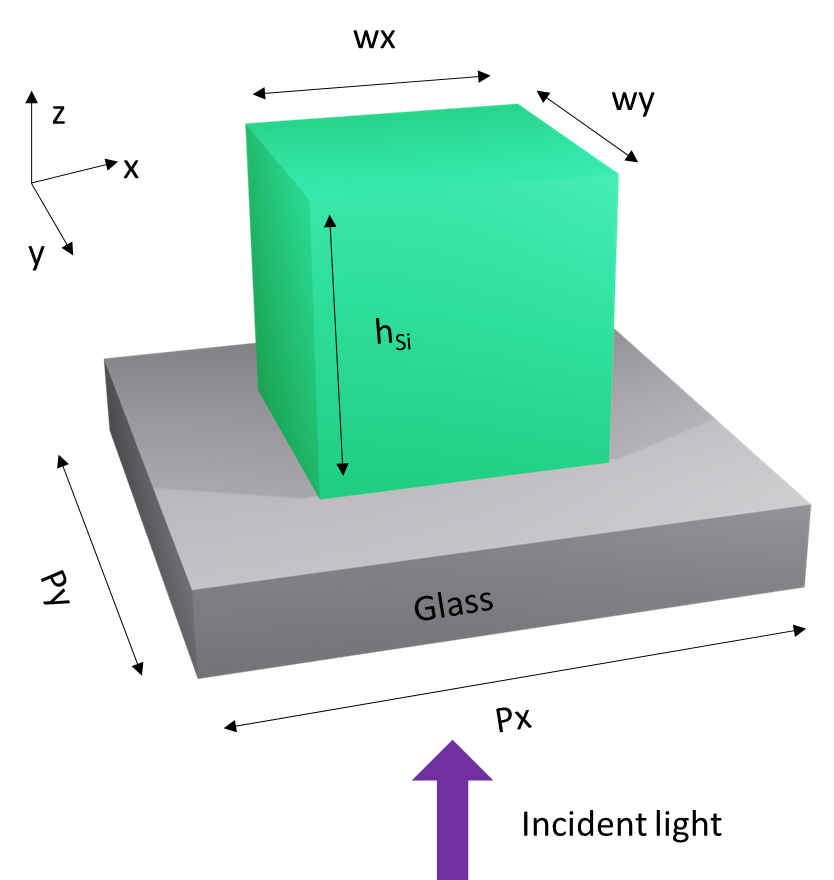

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
path_parent=os.path.dirname(os.getcwd())
sys.path.insert(0,path_parent)

from src import ReadData
from src import rcwa
path_image=path_parent +"/image/Si_atom.png"
from IPython.display import Image
Image(filename=path_image,width=200)

## 1. Optical index

make sure that eps have negative sign: eps=eps1-eps2

In [2]:
wavelength_range=np.array([915])
e_Si=3.65**2
#reflectance and transmission
e_ref=1.45**2; e_trn=1.; 

## 2. Input parameters

In [3]:
sim=rcwa()
sim.setup(wavelength_range=wavelength_range,
        LxLy=[400,400],              # periodic length [Lx,Ly]
        NxNy=[400,400],              # simulation domain [Nx,Ny]
        order=[5,5],                 # diffraction order [mx,my]
        angle=[0,0],                 # [AOI_d,Azimuth_d] in degree             
        e_ref=e_ref,                 # reflected medium
        e_trn=e_trn,                 # transmitted medium
        source='TE',                 # TM - x polarize, or TE- y polarized state                 
            )

## 3. Geometry: 

In [4]:
# Sweep 
W_range=np.linspace(60,260,201)

Structure=[]
for W_i in W_range:
    layer=sim.Geometry.layer()
    mask=sim.Geometry.Rectangle(Wx=W_i,Wy=W_i) 
    layer['medium']={'eps':1,'eps_name':'air','h':500}
    layer['pattern']={'eps':e_Si, 'eps_name':'Si','mask':mask}
    Structure.append(layer) 

C:\Users\hpham\Desktop\RCWA_numpy\src\Geometry.py:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


## 4. Visualization

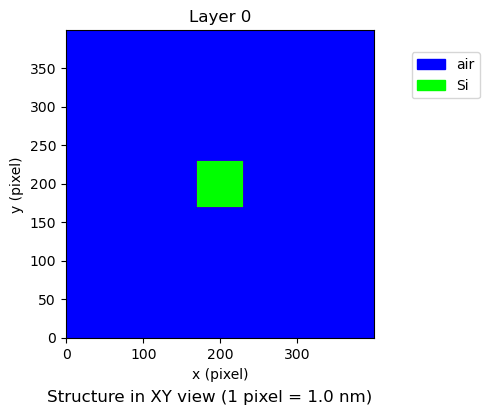

In [5]:
sim.Plot.XY(Structure,layer_position=[0])

## 5. Simulation

In [6]:
t0=time.time()

S_layer=sim.S_layer(Structure,idx=0) 

Trn=[];   Tx=[];    Ty=[] 
for lth in  range(len(W_range)):            
    S_global=sim.S_System([S_layer[lth]])     
    
    S_global_21=S_global[2];                  
    tx,ty= sim.coeff(S_global_21)  
    
    Tx.append(tx);        Ty.append(ty)    
    
    T=sim.Transmittance(tx,ty)     
    Trn.append(np.sum(T))  
Tx=np.array(Tx); 
Ty=np.array(Ty)

order=sim.Nharm//2
phase=np.unwrap(-np.angle(Ty[:,order]))/2/np.pi
       
#print(time.time() -t0)    

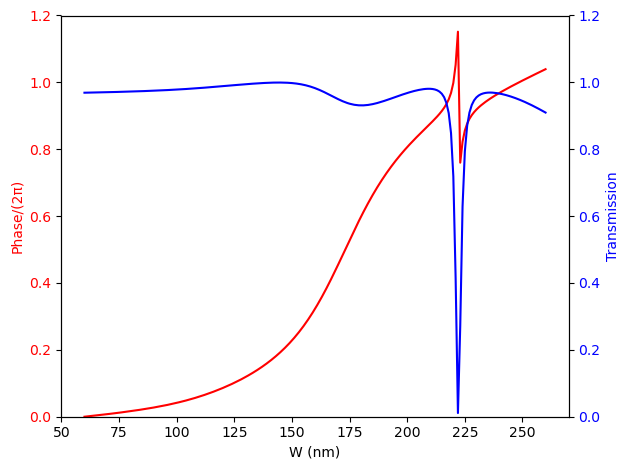

In [7]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('W (nm)')
ax1.set_ylabel('Phase/(2π)', c='r')
ax1.plot(W_range, phase-phase.min(),c='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_ylim([0,1.2])

ax2 = ax1.twinx() 
ax2.set_ylabel('Transmission', c='blue')
ax2.plot(W_range, Trn,c='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim([0,1.2])
fig.tight_layout() 
plt.show()